In [1]:
import numpy as np
from numpy import linalg as LA


import scipy
from scipy import linalg
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

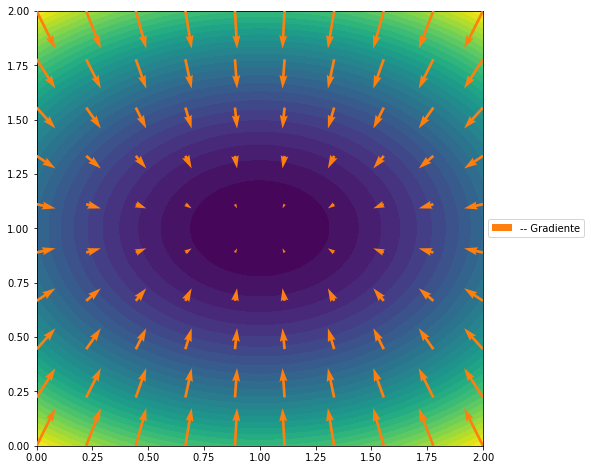

In [2]:
# Vemos que el gradiente (f) apunta hacia el maximo
fig, ax = plt.subplots(figsize=(8, 8))

x = y = np.linspace(0,2,50)
X, Y = np.meshgrid(x,y)
Z = X**2 + 2*Y**2 - 2*X - 4*Y
ax.contourf(X, Y, Z,levels=30,zorder=0)

x1 = y1 = np.linspace(0,2,10)
X1, Y1 = np.meshgrid(x1,y1)
U, V = (-(2*X1 - 2), -(4*Y1 - 4))

ax.quiver(X1, Y1, U, V,color='tab:orange',label="-- Gradiente",zorder=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Sección 6.1 - Problema donde tenemos $n>d$

In [3]:
'''Ejercicio 1'''
# El siguiente codigo genera la data usada en este problema
d = 100 # dimension de la data
n = 1000 # numero de puntos-dato
X = np.random.normal(0,1, size=(n,d)) # cada fila de X es un punto-dato
a_true = np.random.normal(0,1, size=(d,1)) # el a "ideal", que vamos a tener que encontrar
y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1)) # la etiqueta a cada punto-data
y.shape

(1000, 1)

In [4]:
'''Ejercicio 1.a (solucion exacta)'''
# solucion exacta de la regresion
a_learned_exact = ( LA.inv( (X.T).dot(X) ) ).dot(X.T).dot(y)
a_learned_exact.shape

(100, 1)

Comentario: calcular la solución de forma exacta requiere un tiempo computacional que escala como $O(nd^2 + d^3)$, que es muy lento para $d$ grande:

Primeramente, consideremos como a vimos que la regresión lineal se computa como $(X^TX)^{-1} X^TY$

Entonces, si $X$ es una matriz de ($n$x$d$):

1. $(X^T X)$ lleva un tiempo de $O(n*d^2)$ y produce una matriz de ($d$x$d$)

2. La inversión de una matriz ($d$x$d$) consume un tiempo de $O(d^3)$

3. $(X^T Y)$ lleva un tiempo $O(n*d^2)$ y produce una matriz ($d$x$d$)

4. La multiplicación final de dos matrices ($d$x$d$) lleva $O(d^3)$

Por ende, el tiempo computacional Big-O es $O(d^2*(n + d)) = O(nd^2+d^3)$

In [5]:
# Funcion objetivo
def f(b):                      # b:(d,1)
    err = X.dot(b) - y         # X:(n,d), y:(n,1) => err: (n,1)
    f_obj = (err.T).dot(err) 
    return f_obj[0,0]  

zero = np.zeros((d,1))
print("Funcion objetivo f(a) = ", f(a_learned_exact))
print("Funcion objetivo f(0) = ", f(zero))

Funcion objetivo f(a) =  208.93880423653306
Funcion objetivo f(0) =  85702.62027705851


In [6]:
''' Ejercicio 1.b (gradient descent)'''

XT = X.T

def gradient(b):
    return 2*XT.dot(X.dot(b)-y) # dxn(nxd dx1 - nx1)


def gradient_descent(step, iter):
    b = np.zeros((d,1))
    costs = np.zeros(iter + 1)
    costs[0] = f(b)
    for i in range(iter):
        b = b - step * gradient(b)
        costs[i+1] = f(b)
    return b, costs # retorna el vector "b" (minimo aproximado) y 
                    # el array de iter+1 costos, uno para cada paso

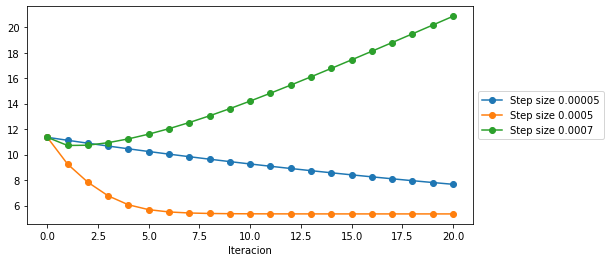

Gradient descent con steps size de 0.00005 =  2136.243608101945
Gradient descent con steps size de 0.0005  =  208.9416300912564
Gradient descent con steps size de 0.0007  =  1150185022.472141
Funcion objetivo exacta                    =  208.93880423653306
Notar que la funcion objetivo con steps size de 0.0005 es casi igual a la exacta


(100, 1)

In [7]:
step_sizes = [0.00005, 0.0005, 0.0007]
As_gd = []
costs_gd = []  # va a terminar siendo una lista de 3 elementos, donde cada elemento es un array
               # conteniendo las 21 funcion objetivo de cada paso
for step in step_sizes:
    b, cost = gradient_descent(step, 20)
    As_gd.append(b)
    costs_gd.append(cost)
    
x = np.linspace(0, 20, 21)
plt.figure(figsize=(8,4))
plt.plot(x, np.log(costs_gd[0]), marker="o", label = "Step size 0.00005") # graficamos los logartitmos de la funcion
plt.plot(x, np.log(costs_gd[1]), marker="o", label = "Step size 0.0005")  # objetivo
plt.plot(x, np.log(costs_gd[2]), marker="o", label = "Step size 0.0007")
plt.xlabel("Iteracion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper right')
plt.show()

print("Gradient descent con steps size de 0.00005 = ", costs_gd[0][20])
print("Gradient descent con steps size de 0.0005  = ", costs_gd[1][20])
print("Gradient descent con steps size de 0.0007  = ", costs_gd[2][20])
print("Funcion objetivo exacta                    = ", f(a_learned_exact))
print("Notar que la funcion objetivo con steps size de 0.0005 es casi igual a la exacta")
a_learned_gd = As_gd[1]
a_learned_gd.shape

El parámetro $\alpha$, que refiere al step size o bien llamado "learning rate", influye de manera determinante en el resultado de la convergencia de nuestro algoritmo de gradient descent. La razón subyacente es que, suponiendo una función objetivo (loss o risk function) convexa, si nuestro learning rate es muy grande, cuando esté cerca a encontrar el mínimo global el algoritmo no puede llegar (exactamente) a él nunca porque "errará" su paso al ponderar más el valor del gradiente. Visto en una imágen:

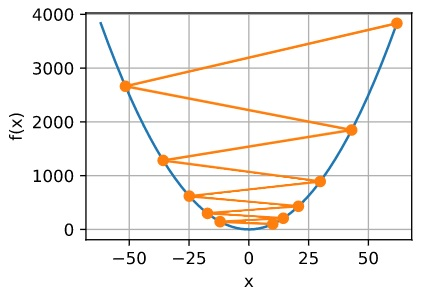

Mientras que lo que buscamos es un learning rate que permita alcanzar el punto más próximo al mínimo global, lo que significa que cuanto más cerca del mínimo esté, pasos más pequeños deberá hacer. Visto en una imágen:

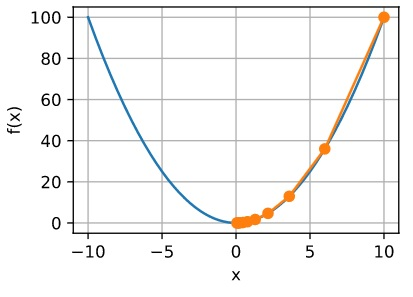

Entendido esto, surge la pregunta de "_¿Cómo hallar entonces un learning rate óptimo, si es que existe?_". De aquí que en la parte de "Hyperparameter Tunning" en cualquier proyecto de Machine Learning, el hiperparámetro $\alpha$ es uno de los más importantes a la hora de ser calibrados.

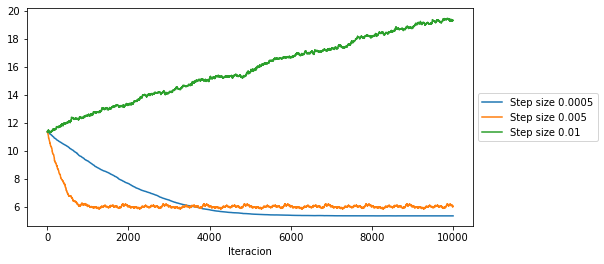

Stochastic GD con steps size de 0.0005   =  211.3591431728752
Stochastic GD con steps size de 0.005    =  424.67754900415116
Stochastic GD con steps size de 0.01     =  242448708.53923327
Funcion objetivo exacta                  =  208.93880423653306


(100, 1)

In [8]:
''' Ejercicio 1.c (stochastic gradient descent)'''
def grad_stoch(b, x, y):  # b:(d,1), x:(d,1), y un numero
    return 2*((b.T).dot(x) - y)*x  # (d,1)

# notar que como la funcion f no esta dividida por n, su gradiente exacto,
# usado en 1.b es la suma de 1000 terminos como este. Por lo tanto
# este gradiente esta efectivamente "escalado" por 1/1000. Tener esto en cuenta
# al comparar el tamano de los pasos aca y en 1.b. La comparacion
# correcta seria dividir los step_sizes_sgd por 1000

def st_gradient_descent(step, iter):
    b = np.zeros((d,1))
    costs_sgd = np.zeros(iter + 1)
    costs_sgd[0] = f(b)
    for i in range(iter):  
        b = b - step * grad_stoch(b, X[i%n,:].reshape(d,1), y[i%n]) # i%n es el remanente de la division entera
        costs_sgd[i+1] = f(b)
    return b, costs_sgd # retorna el vector "b" (minimo aproximado) y 
                        # el array de iter+1 costos, uno para cada paso

epoch = 10    # probar haciendo epoch mas grande
iter = 1000*epoch  
step_sizes_sgd = [0.0005, 0.005, 0.01]
As_sgd = []
costs_sgd = []  # va a terminar siendo una lista de 3 elementos, donde cada elemento es un array
                # conteniendo las 1000 funcion objetivo de cada paso
for step in step_sizes_sgd:
    b, cost_sgd = st_gradient_descent(step, iter)
    As_sgd.append(b)
    costs_sgd.append(cost_sgd)



# b, costs_stgd = st_gradient_descent(step, iter)

plt.figure(figsize=(8,4))
x_sgd = np.linspace(0, iter, iter + 1)

plt.plot(x_sgd, np.log(costs_sgd[0]), label = "Step size 0.0005")
plt.plot(x_sgd, np.log(costs_sgd[1]), label = "Step size 0.005")
plt.plot(x_sgd, np.log(costs_sgd[2]), label = "Step size 0.01")

plt.xlabel("Iteracion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


print("Stochastic GD con steps size de 0.0005   = ", costs_sgd[0][iter])
print("Stochastic GD con steps size de 0.005    = ", costs_sgd[1][iter])
print("Stochastic GD con steps size de 0.01     = ", costs_sgd[2][iter])
print("Funcion objetivo exacta                  = ", f(a_learned_exact))

a_learned_sgd = As_sgd[0]  # poner la mas cercana a la exacta
a_learned_sgd.shape

Nuestro step size, para el caso del Stochastic Gradient Descent, afecta de igual manera a la convergencia del algoritmo que en el caso del Gradient Descent simple, con la diferencia de que, como se puede apreciar en el gráfico, la trayectoria de la convergencia es más "ruidosa".

¿De qué manera podemos optimizar el valor del hiperparámetro step size? Existen, para el stochastic gradient descent, formas de convertir el learning rate en dinámico, es decir, se puede hacer time-dependent el parámetro y controlar mejor la convergencia del algoritmo. Se necesita descubrir qué tan rápido $\alpha$ debe decrecer. Si es muy rápido, nos detendríamos antes, lo cual es malo, si es muy lento perdemos mucho tiempo en optimizar, otra desventaja. Las estrategias básicas son:

\begin{split}\begin{aligned}
    \alpha(t) & = \alpha_i \text{ si } t_i \leq t \leq t_{i+1}  && \text{Piecewise Constant} \\
    \alpha(t) & = \alpha_0 \cdot e^{-\lambda t} && \text{Decrecimiento exponencial} \\
    \alpha(t) & = \alpha_0 \cdot (\beta t + 1)^{-\theta} && \text{Decrecimiento polinómico}
\end{aligned}\end{split}


En el primer escenario "constante por partes" (piecewise constant), disminuimos la tasa de aprendizaje, por ejemplo, cuando el progreso en la optimización se detiene. Esta es una estrategia común para entrenar Deep Neural Networks. Alternativamente, podríamos disminuirlo de manera mucho más agresiva mediante una "disminución exponencial". Desafortunadamente, esto a menudo conduce a una parada prematura antes de que el algoritmo haya convergido, lo cual es malo. Otra opción popular es la "desintegración polinómica" con $\theta=0.5$ . 


Comparación del desempeño de ambos algoritmos:

Para el caso del Gradient Descent, vemos que su mejor aproximación fue con un learning rate de $\alpha=0.0005$, con una cantidad de 20 iteraciones. El error de aproximación fue mínimo, rondando los $0.0013481$.

Para el caso del Stochastic Gradient Descent, su mejor performance y aproximación fue para un step size de $\alpha=0.0005$, con una cantidad cercana a las 10.000 iteraciones y un error de aproximación de alrededor de $2.482010$.

- Entre las conclusiones que podemos hacer, está que a menor step size, de mayor calidad será nuestra solución de aproximación numérica respecto el valor exacto de la función objetivo. 
- Sin embargo, aunque hayan utilizado el mismo step size ambos algoritmos, notese que si en Gradient Descent normal aumentamos el learning-rate, la aproximación diverge _mucho_ más que en el caso de SGD.
- El Stochastic Gradient Descent utiliza más iteraciones, con menos costo computacional.

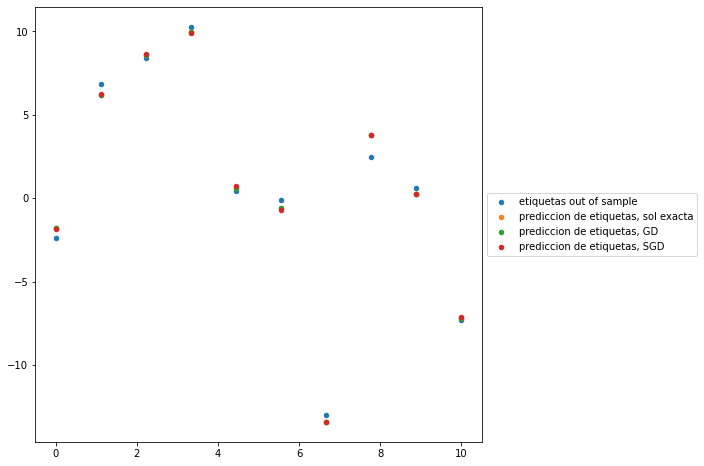

In [9]:
# Veamos que tan bien aprendió la maquina testeandola en un "test set" generado con la misma distribucion
n_out = 10
X_out = np.random.normal(0,1, size=(n_out,d)) # cada fila de X es un punto-dato
y_out = X_out.dot(a_true) + np.random.normal(0,0.5,size=(n_out,1)) # la etiqueta a cada punto-data

y_pred_exact = X_out.dot(a_learned_exact)
y_pred_gd = X_out.dot(a_learned_gd)
y_pred_sgd = X_out.dot(a_learned_sgd)


x_out = np.linspace(0, n_out, n_out)

fig, ax = plt.subplots(figsize=(8,8))



ax.scatter(x_out, y_out, label = "etiquetas out of sample", s = 20)
ax.scatter(x_out, y_pred_exact, label = "prediccion de etiquetas, sol exacta", s = 20)
ax.scatter(x_out, y_pred_gd, label = "prediccion de etiquetas, GD", s = 20)
ax.scatter(x_out, y_pred_sgd, label = "prediccion de etiquetas, SGD", s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Podemos observar que las predicciones para las etiquetas Out-of-Sample son similares a la realización de dichas etiquetas, es decir, que hay un test error bajo. Asimismo, las predicciones calculadas con el método de optimización Gradient Descent o Stochastic Gradient Descent son, para este caso, similares. Visto en los gráficos resultados vemos:

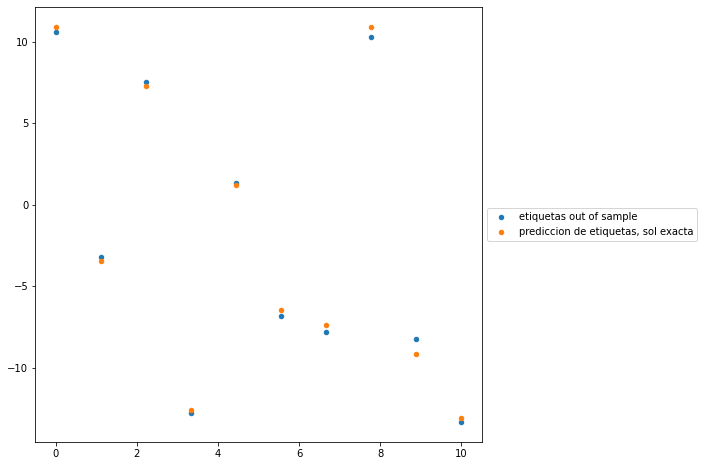

Incorporando las predicciones con optimización Gradient Descent: 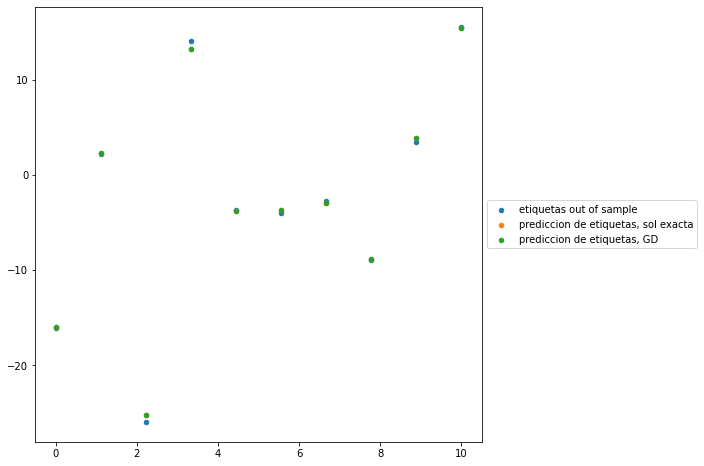

Finalmente, con las predicciones vía optimización Stochastic GD:

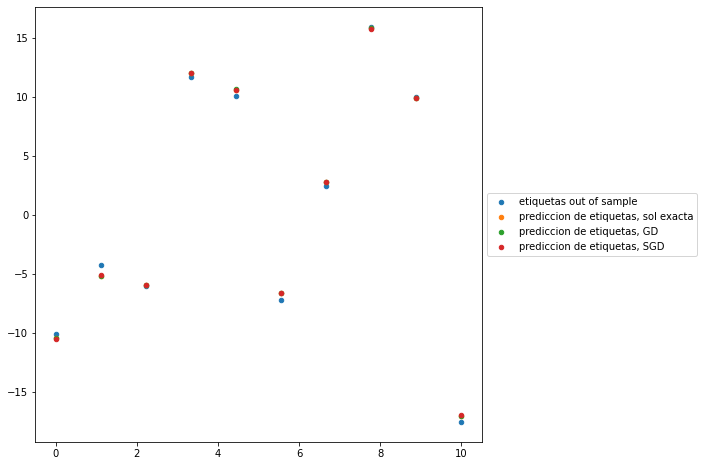

In [10]:
def f_hat(X, a, y):   # calcula el error normalizado
    y_pred = X.dot(a)
    err = y_pred - y
    err2 = (err.T).dot(err)
    norm2 = (y.T).dot(y)
    err_norm = np.sqrt(err2/norm2)
    return err_norm[0,0]

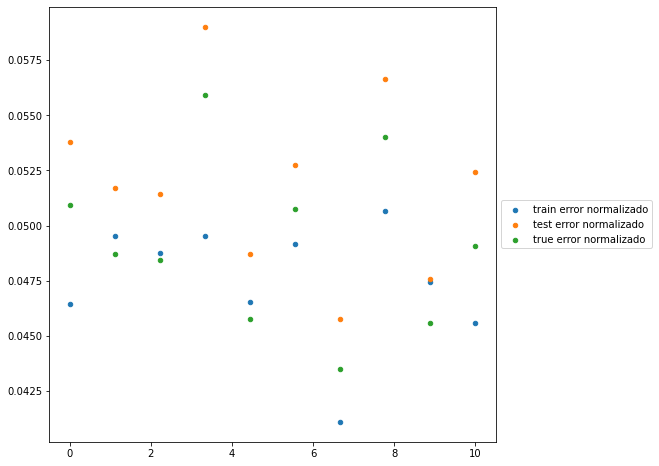

average train error over 10 trials  =  0.04748044036424926
average test error over 10 trials   =  0.05197998293838296
ratio test error / training error   =  1.0947662350983935
notar que el 'training error' es muy parecido al test error,
es decir, la maquina puede generalizar porque n_train >> d


En situaciones reales no conocemos el 'true error', pero en este estudio si,
comparemos el true error con el train y el test error
average true error over 10 trials   =  0.049266314390776736
ratio test error / true error       =  1.0550816228322177
ratio train error / true error      =  0.9637506062994269
aunque muy parecidos, el train error es < que el true error, ¿por que?
¿Por que 'train error' < 'true error' < 'test error'?


In [11]:
trials = 10

train_n = 1000
test_n = 1000
d = 100


error_train = np.zeros(trials)
error_test  = np.zeros(trials)
error_true  = np.zeros(trials)

for i in range(trials):
    X_train = np.random.normal(0,1, size=(train_n,d))                        # (100, 100)
    a_true = np.random.normal(0,1, size=(d,1))                               # (100, 1)
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1)) # (100, 1)
    X_test = np.random.normal(0,1, size=(test_n,d))     # (1000, 100)
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))    # (1000, 1)
    
    a_learned_exact = ( LA.inv( (X_train.T).dot(X_train) ) ).dot(X_train.T).dot(y_train)

    error_train[i] = f_hat(X_train, a_learned_exact, y_train)
    error_test[i] = f_hat(X_test, a_learned_exact, y_test)
    error_true[i] = f_hat(X_test, a_true, y_test)

average_error_train = np.mean(error_train)
average_error_test = np.mean(error_test)
average_error_true = np.mean(error_true)

fig, ax = plt.subplots(figsize=(8,8))

x = np.linspace(0, trials, trials)

ax.scatter(x, error_train, label = "train error normalizado", s = 20)
ax.scatter(x, error_test, label = "test error normalizado", s = 20)
ax.scatter(x, error_true, label = "true error normalizado", s = 20)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print("average train error over 10 trials  = ", average_error_train)
print("average test error over 10 trials   = ", average_error_test)
print("ratio test error / training error   = ", average_error_test/average_error_train)
print("notar que el 'training error' es muy parecido al test error,")
print("es decir, la maquina puede generalizar porque n_train >> d")
print("\n")
print("En situaciones reales no conocemos el 'true error', pero en este estudio si,")
print("comparemos el true error con el train y el test error")
print("average true error over 10 trials   = ", average_error_true)
print("ratio test error / true error       = ", average_error_test/average_error_true)
print("ratio train error / true error      = ", average_error_train/average_error_true)
print("aunque muy parecidos, el train error es < que el true error, ¿por que?")
print("¿Por que 'train error' < 'true error' < 'test error'?")

Para esta situación, en la cual conocemos nuestro error verdadero, 'true error', y podemos compararlo con el training error y test error, vemos una relación 'train error' < 'true error' < 'test error'. 

Una de las razones por la cual se puede interpretar que nuestro 'training error' sea menor que el error verdadero y de testeo, es porque el modelo está sobreajustando a los datos de entrenamiento, es decir, hay overfitting. A su vez, esto significa que nuestro modelo no generaliza bien (como puede apreciarse el test error es el mayor de todos). 

Por lo general, el 'true error' (y también el error humano o error óptimo Bayesiano) debería ser el más bajo de todos ya que la precisión es mayor, pero si entrenando nuestro modelo vemos que se comporta demasiado bien, es un indicio de overfitting y deberiamos ampliar el dataset, aplicar regularization o emplear otras tecnicas para jugar con el bias-variance trade-off y reducir la varianza (el overfitting es sinónimo de alta varianza).

Para el caso contrario, donde tendríamos un training error mucho mayor, en términos relativos, significaría que tenemos mucho sesgo (high bias) y estamos en una situación de "underfitting".

### Sección 6.2 - Problema donde tenemos $n=d$

A continuación desarrollaremos el problema de aprendizaje supervisado con regresión lineal para el caso donde la cantidad de parámetros será igual a la cantidad de datos que tenemos. 

Por el bien del ejercicio, reduciremos $n$ al valor de $d=100$ que ya teníamos de antes, dado que si por el contrario incrementamos $d$ hasta $n=1000$ (la cantidad de datos para los ejercicios de la sección 6.1) estaremos incrementando el costo computacional de manera considerable y no es eficiente bajo ningún aspecto.

#### Idem ejercicio 1 sección 6.1, con $n=d$

In [12]:
'''(Idem) Ejercicio 1 con n==d'''
d = 100 # dimension de la data 
n = 100 # numero de puntos-dato
X = np.random.normal(0,1, size=(n,d)) # cada fila de X es un punto-dato
a_true = np.random.normal(0,1, size=(d,1)) # el a "ideal", que vamos a tener que encontrar
y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1)) # la etiqueta a cada punto-data
y.shape

(100, 1)

In [13]:
'''Ejercicio 1.a (solucion exacta)'''
a_learned_exact = ( LA.inv( (X.T).dot(X) ) ).dot(X.T).dot(y)
a_learned_exact.shape

(100, 1)

In [14]:
# Funcion objetivo
def f(b):                      # b:(d,1)
    err = X.dot(b) - y         # X:(n,d), y:(n,1) => err: (n,1)
    f_obj = (err.T).dot(err)
    return f_obj[0,0]  

zero = np.zeros((d,1))
print("Funcion objetivo f(a) = ", f(a_learned_exact))
print("Funcion objetivo f(0) = ", f(zero))

Funcion objetivo f(a) =  1.5420969409264165e-20
Funcion objetivo f(0) =  8607.41521928859


In [15]:
''' Ejercicio 1.b (gradient descent)'''

XT = X.T

def gradient(b):
    return 2*XT.dot(X.dot(b)-y) # dxn(nxd dx1 - nx1)


def gradient_descent(step, iter):
    b = np.zeros((d,1))
    costs = np.zeros(iter + 1)
    costs[0] = f(b)
    for i in range(iter):
        b = b - step * gradient(b)
        costs[i+1] = f(b)
    return b, costs # retorna el vector "b" (minimo aproximado) y el array de iter+1 costos, uno para cada paso

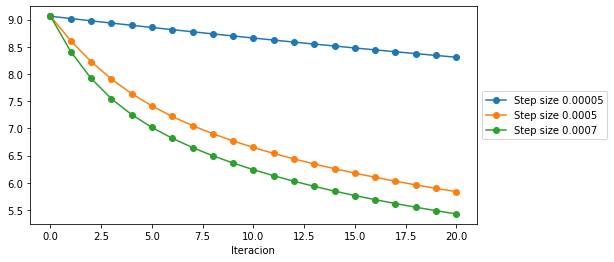

Gradient descent con steps size de 0.00005 =  4052.807899524613
Gradient descent con steps size de 0.0005  =  342.7669011298526
Gradient descent con steps size de 0.0007  =  227.88419946359448
Funcion objetivo exacta                    =  1.5420969409264165e-20


(100, 1)

In [16]:
step_sizes = [0.00005, 0.0005, 0.0007]
As_gd = []
costs_gd = []  
for step in step_sizes:
    b, cost = gradient_descent(step, 20)
    As_gd.append(b)
    costs_gd.append(cost)
    
x = np.linspace(0, 20, 21)
plt.figure(figsize=(8,4))
plt.plot(x, np.log(costs_gd[0]), marker="o", label = "Step size 0.00005") # graficamos los logartitmos de la funcion
plt.plot(x, np.log(costs_gd[1]), marker="o", label = "Step size 0.0005")  # objetivo
plt.plot(x, np.log(costs_gd[2]), marker="o", label = "Step size 0.0007")
plt.xlabel("Iteracion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("Gradient descent con steps size de 0.00005 = ", costs_gd[0][20])
print("Gradient descent con steps size de 0.0005  = ", costs_gd[1][20])
print("Gradient descent con steps size de 0.0007  = ", costs_gd[2][20])
print("Funcion objetivo exacta                    = ", f(a_learned_exact))
a_learned_gd = As_gd[1]
a_learned_gd.shape

Podemos notar que para los learning rates (Step sizes) elegidos, **ninguna aproximación** es casi igual a la solución exacta.

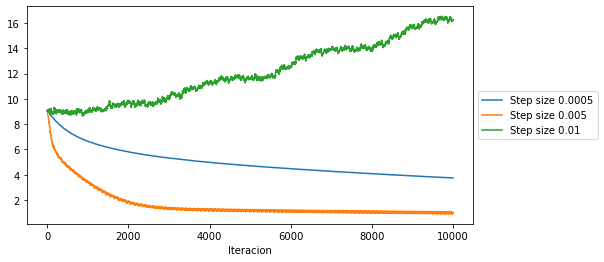

Stochastic GD con steps size de 0.0005   =  42.31676880969718
Stochastic GD con steps size de 0.005    =  2.8085820303839144
Stochastic GD con steps size de 0.01     =  11121436.558363877
Funcion objetivo exacta                  =  1.5420969409264165e-20


(100, 1)

In [17]:
''' Ejercicio 1.c (stochastic gradient descent)'''
def grad_stoch(b, x, y):  # b:(d,1), x:(d,1), y un numero
    return 2*((b.T).dot(x) - y)*x  # (d,1)

def st_gradient_descent(step, iter):
    b = np.zeros((d,1))
    costs_sgd = np.zeros(iter + 1)
    costs_sgd[0] = f(b)
    for i in range(iter):  
        b = b - step * grad_stoch(b, X[i%n,:].reshape(d,1), y[i%n]) # i%n es el remanente de la division entera
        costs_sgd[i+1] = f(b)
    return b, costs_sgd

epoch = 10    # probar haciendo epoch mas grande
iter = 1000*epoch  
step_sizes_sgd = [0.0005, 0.005, 0.01]
As_sgd = []
costs_sgd = []  

for step in step_sizes_sgd:
    b, cost_sgd = st_gradient_descent(step, iter)
    As_sgd.append(b)
    costs_sgd.append(cost_sgd)


plt.figure(figsize=(8,4))
x_sgd = np.linspace(0, iter, iter + 1)

plt.plot(x_sgd, np.log(costs_sgd[0]), label = "Step size 0.0005")
plt.plot(x_sgd, np.log(costs_sgd[1]), label = "Step size 0.005")
plt.plot(x_sgd, np.log(costs_sgd[2]), label = "Step size 0.01")

plt.xlabel("Iteracion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


print("Stochastic GD con steps size de 0.0005   = ", costs_sgd[0][iter])
print("Stochastic GD con steps size de 0.005    = ", costs_sgd[1][iter])
print("Stochastic GD con steps size de 0.01     = ", costs_sgd[2][iter])
print("Funcion objetivo exacta                  = ", f(a_learned_exact))

a_learned_sgd = As_sgd[0]  # poner la mas cercana a la exacta
a_learned_sgd.shape

Con Stochastic Gradient Descent, por el contrario, para cuando usamos un learning rate de 0.005 la solución se aproxima más a la exacta, aunque no sea "casi igual"...

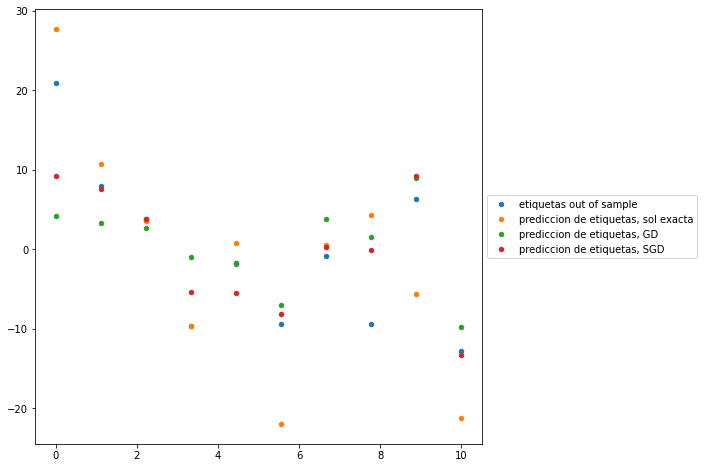

In [18]:
# Veamos que tan bien aprendió la maquina testeandola en un "test set" generado con la misma distribucion
n_out = 10
X_out = np.random.normal(0,1, size=(n_out,d)) # cada fila de X es un punto-dato
y_out = X_out.dot(a_true) + np.random.normal(0,0.5,size=(n_out,1)) # la etiqueta a cada punto-data

y_pred_exact = X_out.dot(a_learned_exact)
y_pred_gd = X_out.dot(a_learned_gd)
y_pred_sgd = X_out.dot(a_learned_sgd)

x_out = np.linspace(0, n_out, n_out)
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x_out, y_out, label = "etiquetas out of sample", s = 20)
ax.scatter(x_out, y_pred_exact, label = "prediccion de etiquetas, sol exacta", s = 20)
ax.scatter(x_out, y_pred_gd, label = "prediccion de etiquetas, GD", s = 20)
ax.scatter(x_out, y_pred_sgd, label = "prediccion de etiquetas, SGD", s = 20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Podemos notar que el gráfico, a diferencia del ejercicio anterior, difiere considerablemente en relación a los puntos de predicciones según cada algoritmo de aprendizaje utilizado. 

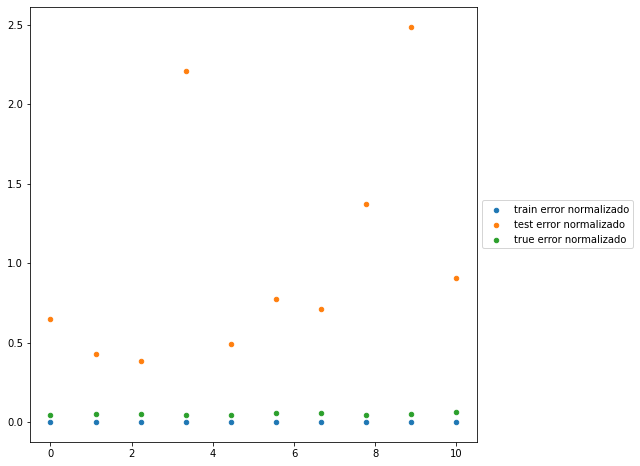

average train error over 10 trials  =  4.295414231721383e-12
average test error over 10 trials   =  1.0415374262798802
ratio test error / training error   =  242476597155.21436


En situaciones reales no conocemos el 'true error', pero en este estudio si,
comparemos el true error con el train y el test error
average true error over 10 trials   =  0.05006652559267557
ratio test error / true error       =  20.803069794646404
ratio train error / true error      =  8.579413452148507e-11


In [20]:
trials = 10

train_n = 100
test_n = 100
d = 100


error_train = np.zeros(trials)
error_test  = np.zeros(trials)
error_true  = np.zeros(trials)

for i in range(trials):
    X_train = np.random.normal(0,1, size=(train_n,d))                        # (100, 100)
    a_true = np.random.normal(0,1, size=(d,1))                               # (100, 1)
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1)) # (100, 1)
    X_test = np.random.normal(0,1, size=(test_n,d))     # (1000, 100)
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))    # (1000, 1)
    
    a_learned_exact = ( LA.inv( (X_train.T).dot(X_train) ) ).dot(X_train.T).dot(y_train)

    error_train[i] = f_hat(X_train, a_learned_exact, y_train)
    error_test[i] = f_hat(X_test, a_learned_exact, y_test)
    error_true[i] = f_hat(X_test, a_true, y_test)

average_error_train = np.mean(error_train)
average_error_test = np.mean(error_test)
average_error_true = np.mean(error_true)

fig, ax = plt.subplots(figsize=(8,8))

x = np.linspace(0, trials, trials)

ax.scatter(x, error_train, label = "train error normalizado", s = 20)
ax.scatter(x, error_test, label = "test error normalizado", s = 20)
ax.scatter(x, error_true, label = "true error normalizado", s = 20)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print("average train error over 10 trials  = ", average_error_train)
print("average test error over 10 trials   = ", average_error_test)
print("ratio test error / training error   = ", average_error_test/average_error_train)
print("\n")
print("En situaciones reales no conocemos el 'true error', pero en este estudio si,")
print("comparemos el true error con el train y el test error")
print("average true error over 10 trials   = ", average_error_true)
print("ratio test error / true error       = ", average_error_test/average_error_true)
print("ratio train error / true error      = ", average_error_train/average_error_true)

Notese que para el ejercicio 1 (sección 6.1) cuando $n>d$ el ratio de test error/training error fue de $\frac{Test_E}{Train_E}=1.1091$, que significaba que ambos errores eran relativamente similares y eso significa que el modelo podía generalizar bien. Por el contrario, para este caso cuando $n=d$ el ratio que obtuvimos fue de $\frac{Test_E}{Train_E}=142386466591$ algo que carece de lógica si queremos considerar que el modelo generalice. Podemos ver que el train error < test error por una magnitud muy grande. 


Esto significa, como ya hemos comentado anteriormente, que el modelo posee una excelente performance en el entrenamiento, pero un mal desempeño a la hora de testearlo, o sea, generalizar. Claramente estamos ante un caso de **Overfitting** (sobreajuste) cuando $n=d$.

A continuación, en los subsiguientes ejercicios, haremos un tratamiento para este problema y poder reducir el sobreajuste por medio de un método de regularización.

#### Ejercicio 2

In [42]:
"""2.b - Problema con Regularización"""

# Funcion objetivo con L2 Regularization
def f(b, lmbda):                      # b:(d,1)
    err = X.dot(b) - y         # X:(n,d), y:(n,1) => err: (n,1)
    f_obj = (err.T).dot(err) + lmbda*(err**2)
    return f_obj[0,0]  

zero = np.zeros((d,1))
print("Funcion objetivo f(a) = ", f(a_learned_exact,0))
print("Funcion objetivo f(0) = ", f(zero,0))

Funcion objetivo f(a) =  4.35315496690806e-21
Funcion objetivo f(0) =  13286.409328961763


Tal como se indica, para poder aplicar regularización, entre todos los métodos existentes, eligiremos aplicar "**L2 Regularization**". 

El nuevo término incorporado $\lambda\cdot||a||^2_2$ es el regularizador L2. Tenemos el caso particular en el que si $\lambda=0$, la función de costo sigue siendo igual que antes.

In [43]:
'''Solucion exacta con Regularización'''
# solucion exacta de la regresion con regularizador L2: la constante es lambda*I

I = np.identity(d)
lmbda = 0.005

a_learned_exact = ( LA.inv( (X.T).dot(X)+lmbda*I ) ).dot(X.T).dot(y)
a_learned_exact.shape

(100, 1)

In [ ]:
lambda_values = [0.0, 0.00005, 0.0005, 0.005, 0.05, 0.5, 5, 50, 500, 5000]  # parametros Lambda a usar, llamar por list[i]

